In [2]:
import os
import re
import pandas as pd
import datetime
import numpy as np
import seaborn as sns
import nltk
from textblob import TextBlob
import statsmodels.api as sm
from wordcloud import WordCloud
import matplotlib.pyplot as plt 
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation

In [3]:
data = []

# Load data from text files and populate the list
for index, file_name in enumerate(sorted(os.listdir("article_texts"))):
    if file_name.endswith(".txt"):
        file_path = os.path.join("article_texts", file_name)
        with open(file_path, "r", encoding="utf-8") as file:
            lines = file.readlines()
            
            # Check if the file has at least 4 lines before proceeding
            if len(lines) >= 4:
                title = lines[0].replace("Title: ", "").strip()
                author = lines[1].replace("Author: ", "").strip()
                date_time = lines[2].replace("Date/Time: ", "").strip()
                url = lines[3].replace("URL: ", "").strip()

                # Remove patterns like $30,000 from text using regex
                text = "".join(lines[5:]).strip()
                text = re.sub(r'\$\d+(?:,\d+)?', '', text)

                # Get the modification timestamp of the file
                mod_timestamp = os.path.getmtime(file_path)

                data.append([title, author, date_time, url, text, mod_timestamp])
            else:
                print(f"Skipping {file_path} due to insufficient lines.")


# Create a DataFrame
df = pd.DataFrame(data, columns=["Title", "Author", "Date/Time", "URL", "Text", "ModTimestamp"])

# Sort the DataFrame by the "ModTimestamp" column in descending order
df = df.sort_values(by="ModTimestamp", ascending=False)

# Drop the "ModTimestamp" column
df = df.drop(columns=["ModTimestamp"])

# Reset index and assign a new index starting from 1
df = df.reset_index(drop=True)
df.index = df.index + 1


Skipping article_texts/skipped_count.txt due to insufficient lines.


In [4]:
df.head()

,Title,Author,Date/Time,URL,Text
1,Bitcoin Supply In Loss Hits A 9-Month Low,Dalmas Ngetich,January 2023,https://www.newsbtc.com/all/bitcoin-supply-in-...,"According to on-chain data from CryptoQuant, a..."
2,Bitcoin Investors Turn Greedy For First Time S...,Hououin Kyouma,January 2023,https://www.newsbtc.com/all/bitcoin-investors-...,Data shows investors in the Bitcoin market hav...
3,Bitcoin Exchange Outflows Reach Highest Value ...,Hououin Kyouma,January 2023,https://www.newsbtc.com/all/bitcoin-outflow-hi...,On-chain data shows Bitcoin exchanges have reg...
4,"U.S. Institutions Are Driving Bitcoin Prices, ...",Best Owie,January 2023,https://www.newsbtc.com/news/bitcoin/u-s-insti...,Bitcoin prices have been on the rise in the la...
5,Cardano (ADA) Leads Crypto Dip as Market Sheds...,News BTC,January 2023,https://www.newsbtc.com/press-releases/cardano...,The crypto market took a dramatic dip this wee...


## EDA 

In [5]:
df.describe()

,Title,Author,Date/Time,URL,Text
count,1046,1046,1046,1046,1046
unique,1028,27,8,1030,1031
top,"Bitcoin Price Surges To $25K, Dips Turn Attrac...",Hououin Kyouma,July 2023,https://www.newsbtc.com/analysis/btc/bitcoin-p...,The cryptocurrency market has experienced sign...
freq,2,171,206,2,2


In [6]:
df.isnull().sum()

Title        0
Author       0
Date/Time    0
URL          0
Text         0
dtype: int64

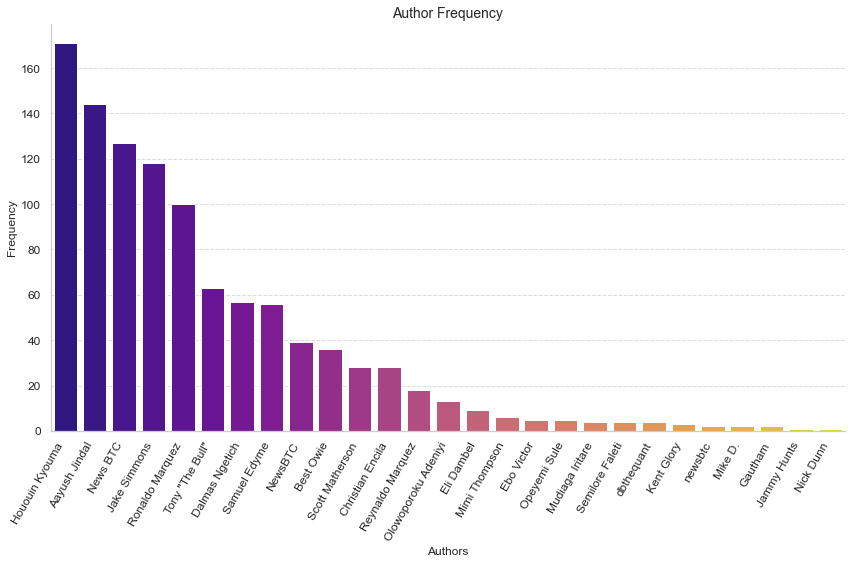

In [41]:
plt.figure(figsize=(12, 8))

author_counts = df['Author'].value_counts()
sns.barplot(x=author_counts.index, y=author_counts.values, palette='plasma') 

plt.xticks(rotation=60, ha='right')  

plt.xlabel('Authors', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.title('Author Frequency', fontsize=14)


plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

sns.despine()

plt.tight_layout()
plt.show()


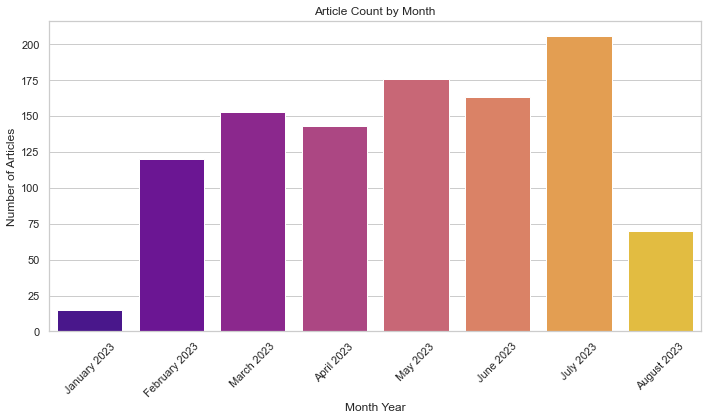

In [8]:
df['Date/Time'] = pd.to_datetime(df['Date/Time'])

df['Month'] = df['Date/Time'].dt.strftime('%B %Y')

monthly_counts = df['Month'].value_counts()

monthly_counts = monthly_counts.reindex(pd.to_datetime(monthly_counts.index, format='%B %Y').sort_values().strftime('%B %Y'))

sns.set(style="whitegrid")
sns.despine

plt.figure(figsize=(10, 6))
sns.barplot(x=monthly_counts.index, y=monthly_counts.values, palette="plasma")
plt.xticks(rotation=45)
plt.xlabel('Month Year')
plt.ylabel('Number of Articles')
plt.title('Article Count by Month')
plt.tight_layout()
plt.show()

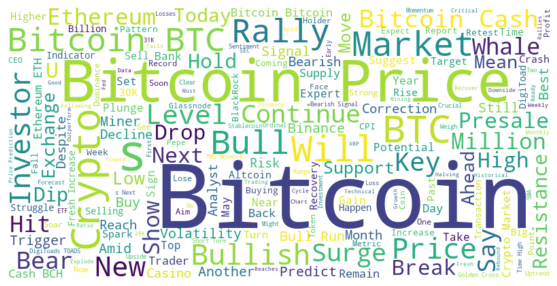

In [9]:
text = ' '.join(df['Title'])
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)

plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

In [10]:
#The Polarity of each article according to the title
df["Polarity_title"] = df["Title"].apply(lambda text: TextBlob(text).sentiment.polarity)
df["Polarity_title"]

1       0.000000
2       0.250000
3       0.000000
4       0.000000
5      -0.166667
          ...   
1042    0.000000
1043    0.250000
1044    0.000000
1045    0.000000
1046    0.100000
Name: Polarity_title, Length: 1046, dtype: float64

In [11]:
def get_sentiment(score):
    if score < 0:
        return 'Negative'
    elif score == 0:
        return 'Neutral'
    else:
        return 'Positive'

df['Sentiment_title'] = df['Polarity_title'].apply(get_sentiment)

df.head()  

,Title,Author,Date/Time,URL,Text,Month,Polarity_title,Sentiment_title
1,Bitcoin Supply In Loss Hits A 9-Month Low,Dalmas Ngetich,2023-01-01,https://www.newsbtc.com/all/bitcoin-supply-in-...,"According to on-chain data from CryptoQuant, a...",January 2023,0.000000,Neutral
2,Bitcoin Investors Turn Greedy For First Time S...,Hououin Kyouma,2023-01-01,https://www.newsbtc.com/all/bitcoin-investors-...,Data shows investors in the Bitcoin market hav...,January 2023,0.250000,Positive
3,Bitcoin Exchange Outflows Reach Highest Value ...,Hououin Kyouma,2023-01-01,https://www.newsbtc.com/all/bitcoin-outflow-hi...,On-chain data shows Bitcoin exchanges have reg...,January 2023,0.000000,Neutral
4,"U.S. Institutions Are Driving Bitcoin Prices, ...",Best Owie,2023-01-01,https://www.newsbtc.com/news/bitcoin/u-s-insti...,Bitcoin prices have been on the rise in the la...,January 2023,0.000000,Neutral
5,Cardano (ADA) Leads Crypto Dip as Market Sheds...,News BTC,2023-01-01,https://www.newsbtc.com/press-releases/cardano...,The crypto market took a dramatic dip this wee...,January 2023,-0.166667,Negative


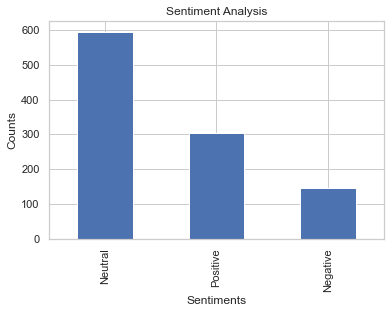

In [12]:
plt.title('Sentiment Analysis')
df['Sentiment_title'].value_counts().plot(kind='bar')
plt.xlabel('Sentiments')
plt.ylabel('Counts')
plt.show()

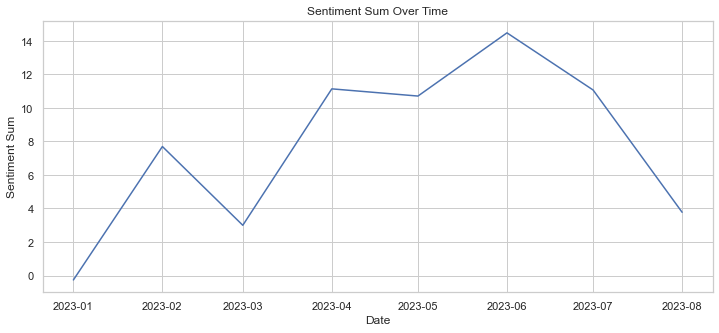

In [13]:
#Plot the sum of the polarity for each month

df['Date/Time'] = pd.to_datetime(df['Date/Time'])

polarity = df.groupby(df['Date/Time'].dt.date)['Polarity_title'].sum()

plt.figure(figsize=(12, 5))
plt.title('Sentiment Sum Over Time')
plt.plot(polarity.index, polarity.values)
plt.xlabel('Date')
plt.ylabel('Sentiment Sum')
plt.grid(True)
plt.show()


In [14]:
# The polarity can only be the values between -1 and 1 
polarity

Date/Time
2023-01-01    -0.260985
2023-02-01     7.696165
2023-03-01     2.998891
2023-04-01    11.134978
2023-05-01    10.705909
2023-06-01    14.474879
2023-07-01    11.066591
2023-08-01     3.774949
Name: Polarity_title, dtype: float64

In [15]:
polarity_count = df.groupby('Date/Time').size()
polarity_count

Date/Time
2023-01-01     15
2023-02-01    120
2023-03-01    153
2023-04-01    143
2023-05-01    176
2023-06-01    163
2023-07-01    206
2023-08-01     70
dtype: int64

In [16]:
df.columns

Index(['Title', 'Author', 'Date/Time', 'URL', 'Text', 'Month',
       'Polarity_title', 'Sentiment_title'],
      dtype='object')

In [17]:
polarity_avg = polarity / polarity_count
polarity_avg

Date/Time
2023-01-01   -0.017399
2023-02-01    0.064135
2023-03-01    0.019601
2023-04-01    0.077867
2023-05-01    0.060829
2023-06-01    0.088803
2023-07-01    0.053721
2023-08-01    0.053928
dtype: float64

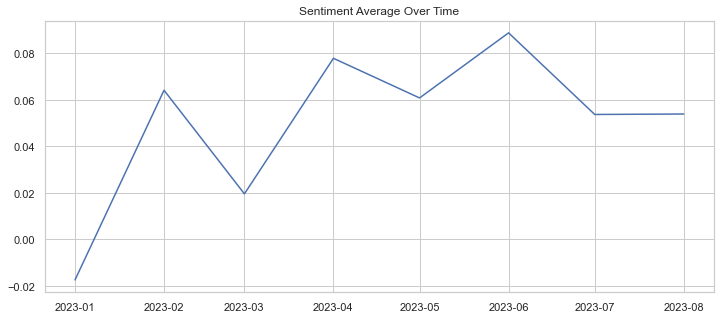

In [18]:
plt.figure(figsize=(12,5))
plt.title('Sentiment Average Over Time')
plt.plot(polarity_avg.index, polarity_avg)
plt.show()

In [19]:
bitcoin_data = pd.read_csv("BTC-USD.csv")

bitcoin_data

,Date,Open,High,Low,Close,Adj Close,Volume
0,2023-01-01,16547.914063,23919.890625,16521.234375,23139.283203,23139.283203,690994018045
1,2023-02-01,23137.835938,25134.117188,21460.087891,23147.353516,23147.353516,723968574897
2,2023-03-01,23150.929688,29159.902344,19628.253906,28478.484375,28478.484375,883299703608
3,2023-04-01,28473.332031,31005.607422,27070.849609,29268.806641,29268.806641,511540319004
4,2023-05-01,29227.103516,29820.126953,25878.429688,27219.658203,27219.658203,443473015479
5,2023-06-01,27218.412109,31389.539063,24797.167969,30477.251953,30477.251953,481734214225
6,2023-07-01,30471.847656,31814.515625,28934.294922,29230.111328,29230.111328,382224489090
7,2023-08-01,29230.873047,30176.796875,25409.111328,25931.472656,25931.472656,437724169499


In [20]:
polarity_df = pd.DataFrame({'Date': polarity.index, 'Polarity Avg': polarity_avg})

bitcoin_data['Date'] = pd.to_datetime(bitcoin_data['Date'])

polarity_df['Date'] = pd.to_datetime(polarity_df['Date'])

merged_data = pd.merge(bitcoin_data, polarity_df, on='Date', how='inner')

merged_data

,Date,Open,High,Low,Close,Adj Close,Volume,Polarity Avg
0,2023-01-01,16547.914063,23919.890625,16521.234375,23139.283203,23139.283203,690994018045,-0.017399
1,2023-02-01,23137.835938,25134.117188,21460.087891,23147.353516,23147.353516,723968574897,0.064135
2,2023-03-01,23150.929688,29159.902344,19628.253906,28478.484375,28478.484375,883299703608,0.019601
3,2023-04-01,28473.332031,31005.607422,27070.849609,29268.806641,29268.806641,511540319004,0.077867
4,2023-05-01,29227.103516,29820.126953,25878.429688,27219.658203,27219.658203,443473015479,0.060829
5,2023-06-01,27218.412109,31389.539063,24797.167969,30477.251953,30477.251953,481734214225,0.088803
6,2023-07-01,30471.847656,31814.515625,28934.294922,29230.111328,29230.111328,382224489090,0.053721
7,2023-08-01,29230.873047,30176.796875,25409.111328,25931.472656,25931.472656,437724169499,0.053928


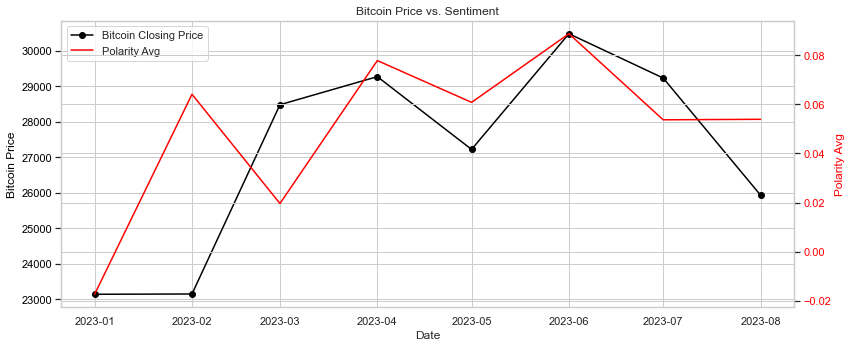

In [21]:
fig, ax1 = plt.subplots(figsize=(12, 5))
plt.title('Bitcoin Price vs. Sentiment')
plt.xlabel('Date')

ax1.plot(merged_data['Date'], merged_data['Close'], label='Bitcoin Closing Price', color='black', linestyle='-', marker='o')
ax1.set_ylabel('Bitcoin Price', color='black')
ax1.tick_params(axis='y', labelcolor='black')

ax2 = ax1.twinx()

ax2.plot(merged_data['Date'], merged_data['Polarity Avg'], label='Polarity Avg', color='red')
ax2.set_ylabel('Polarity Avg', color='red')
ax2.tick_params(axis='y', labelcolor='red')

lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
lines = lines1 + lines2
labels = labels1 + labels2
ax1.legend(lines, labels, loc='upper left')

plt.xticks(rotation=45)

plt.grid(True)
plt.tight_layout()
plt.show()


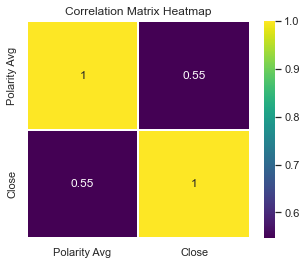

In [22]:
correlation_matrix = merged_data[['Polarity Avg', 'Close']].corr()
plt.figure(figsize=(5, 4))  
sns.set(style="white")  

sns.heatmap(correlation_matrix, annot=True, cmap="viridis", linewidths=0.1)

plt.title("Correlation Matrix Heatmap")
plt.show()


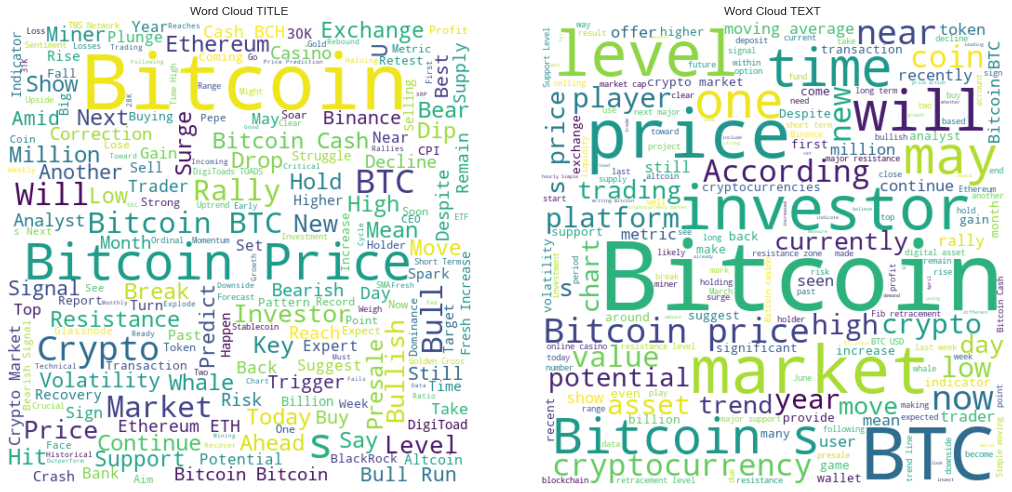

In [23]:
text1 = ' '.join(df['Title'])
text2 = ' '.join(df['Text'])

wordcloud1 = WordCloud(width=500, height=500, background_color='white').generate(text1)

wordcloud2 = WordCloud(width=500, height=500, background_color='white').generate(text2)

plt.figure(figsize=(15, 7))

plt.subplot(1, 2, 1)
plt.imshow(wordcloud1, interpolation='bilinear')
plt.axis("off")
plt.title("Word Cloud TITLE")

plt.subplot(1, 2, 2)
plt.imshow(wordcloud2, interpolation='bilinear')
plt.axis("off")
plt.title("Word Cloud TEXT")

plt.tight_layout()
plt.show()

In [24]:
corpus = df["Text"]

vectorizer = CountVectorizer(max_features=1000, stop_words='english')
X = vectorizer.fit_transform(corpus)

num_topics = 5  
lda_model = LatentDirichletAllocation(n_components=num_topics, random_state=42)
lda_output = lda_model.fit_transform(X)

for i in range(num_topics):
    df[f"Topic {i+1}"] = lda_output[:, i]

df["Sentiment_text"] = df["Text"].apply(lambda text: TextBlob(text).sentiment.polarity)
df['Sentiment_text']

1       0.069253
2      -0.030914
3       0.055424
4       0.132987
5       0.095618
          ...   
1042    0.040889
1043    0.126705
1044    0.105934
1045    0.062064
1046    0.104820
Name: Sentiment_text, Length: 1046, dtype: float64

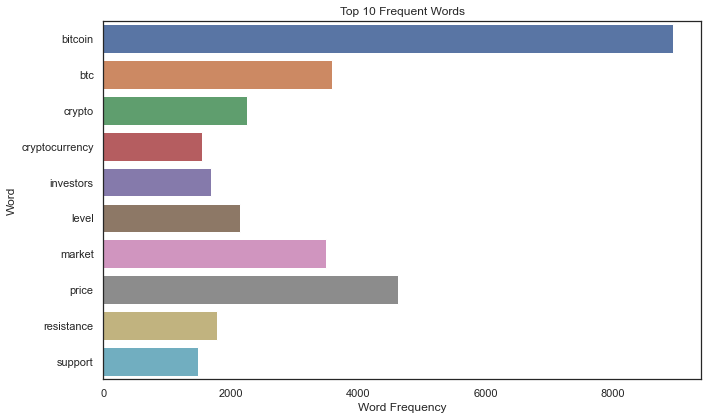

In [25]:
N = 10  # Change this to display more or fewer words
cv = CountVectorizer(stop_words='english', max_features=N)
word_matrix = cv.fit_transform(df['Text'])
word_freq = np.asarray(word_matrix.sum(axis=0)).ravel()
word_names = cv.get_feature_names()

plt.figure(figsize=(10, 6))
sns.barplot(x=word_freq, y=word_names)
plt.xlabel('Word Frequency')
plt.ylabel('Word')
plt.title(f'Top {N} Frequent Words')
plt.tight_layout()
plt.show()


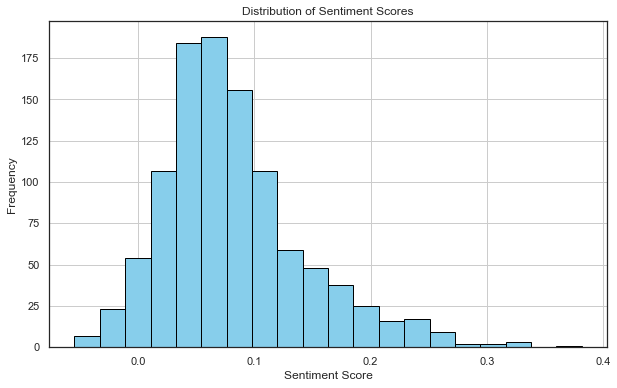

In [26]:
plt.figure(figsize=(10, 6))
plt.hist(df["Sentiment_text"], bins=20, color='skyblue', edgecolor='black')
plt.title("Distribution of Sentiment Scores")
plt.xlabel("Sentiment Score")
plt.ylabel("Frequency")
plt.grid(True)
plt.show()
#plt.savefig("distribution_of_sentiments_scores.png", dpi=200)  
plt.show()

In [27]:
# The top words associated with each topic
def get_top_words(lda_model, vectorizer, n_words=10):
    words = vectorizer.get_feature_names()
    top_words = []
    for topic_weights in lda_model.components_:
        word_indices = topic_weights.argsort()[-n_words:][::-1]
        top_words.append([words[idx] for idx in word_indices])
    return top_words

top_words_per_topic = get_top_words(lda_model, vectorizer)

for i, top_words in enumerate(top_words_per_topic):
    print(f"Topic {i+1}: {', '.join(top_words)}")

Topic 1: resistance, level, price, near, support, zone, major, bitcoin, btc, hourly
Topic 2: bitcoin, crypto, investors, market, presale, network, token, btc, tokens, cryptocurrency
Topic 3: bitcoin, market, price, btc, crypto, time, cryptocurrency, according, bullish, fed
Topic 4: bitcoin, price, btc, market, investors, asset, value, time, trading, cryptocurrency
Topic 5: bitcoin, casino, players, games, crypto, online, gambling, deposit, bonus, casinos


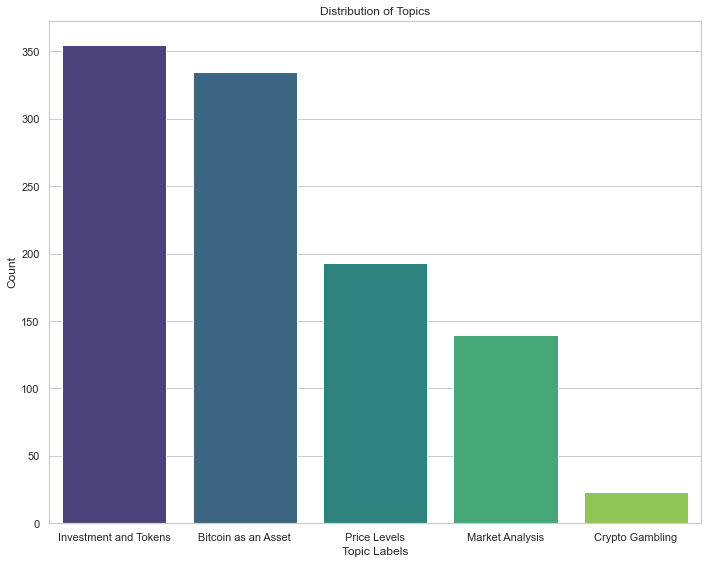

In [28]:
topic_labels = {
    0: "Market Analysis",
    1: "Price Levels",
    2: "Investment and Tokens",
    3: "Bitcoin as an Asset",
    4: "Crypto Gambling"
}

dominant_topic = np.argmax(lda_output, axis=1)

df['Topic Labels'] = [topic_labels[i] for i in dominant_topic]

topic_label_counts = df['Topic Labels'].value_counts()

plt.figure(figsize=(10, 8))
sns.set(style="whitegrid")
sns.barplot(x=topic_label_counts.index, y=topic_label_counts.values, palette="viridis")
plt.title("Distribution of Topics")
plt.xlabel("Topic Labels")
plt.ylabel("Count")
# plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


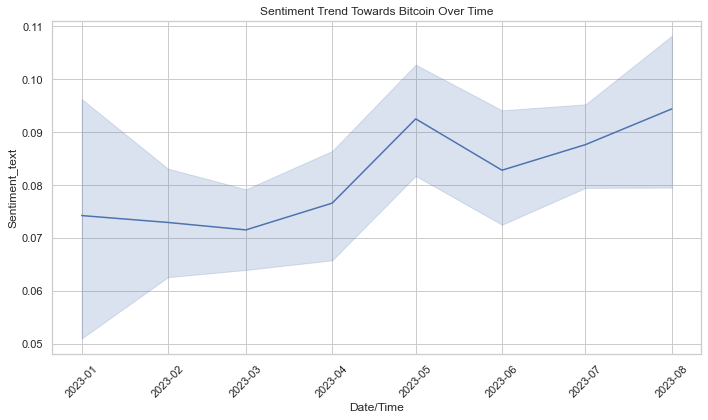

In [31]:
# Visualize sentiment trend over time
sns.set(style="whitegrid")
plt.figure(figsize=(10, 6))
sns.lineplot(data=df, x="Date/Time", y="Sentiment_text")
plt.title("Sentiment Trend Towards Bitcoin Over Time")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

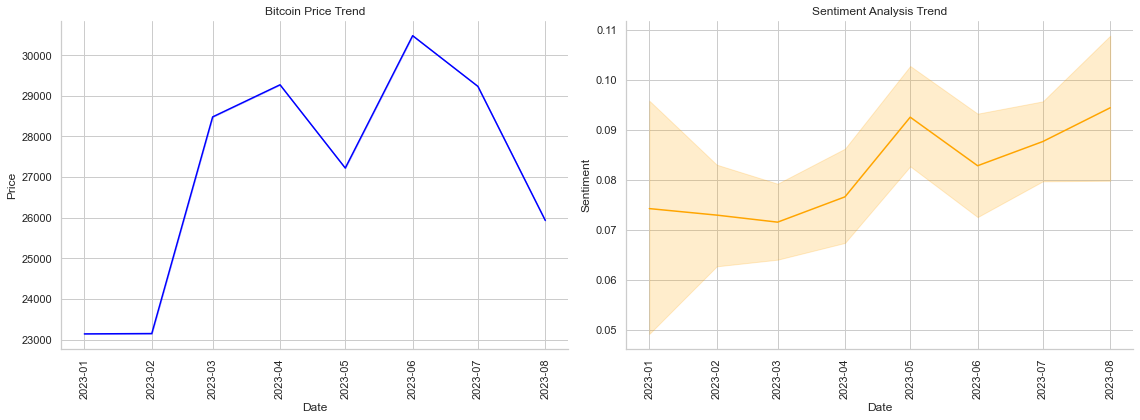

In [32]:
bitcoin_data = pd.read_csv("BTC-USD.csv")

# Convert the 'Date' column to datetime format in the Bitcoin data
bitcoin_data['Date'] = pd.to_datetime(bitcoin_data['Date'])

# Convert the 'Date/Time' column in your df DataFrame to datetime format
df['Date/Time'] = pd.to_datetime(df['Date/Time'])

# Merge sentiment data with Bitcoin price data
merged_data = df.merge(bitcoin_data, how='inner', left_on='Date/Time', right_on='Date')

# Set up the figure and axes using Seaborn style
plt.figure(figsize=(16, 6))  # Increased figsize
sns.set(style="whitegrid")  # Seaborn style

# Plot Bitcoin price trend
ax1 = plt.subplot(121)
sns.lineplot(data=merged_data, x='Date', y='Close', ax=ax1, color='blue')  # Changed color
ax1.set_title("Bitcoin Price Trend")
ax1.set_xlabel("Date")
ax1.set_ylabel("Price")
ax1.tick_params(axis='x', labelrotation=90)  # Rotate x-axis labels
sns.despine()  # Remove spines

# Plot sentiment analysis trend
ax2 = plt.subplot(122)
sns.lineplot(data=merged_data, x='Date', y='Sentiment_text', ax=ax2, color='orange')
ax2.set_title("Sentiment Analysis Trend")
ax2.set_xlabel("Date")
ax2.set_ylabel("Sentiment")
ax2.tick_params(axis='x', labelrotation=90)  # Rotate x-axis labels
sns.despine()  # Remove spines

# Adjust layout to avoid overlapping labels
plt.tight_layout()

# Save the figures as image files
plt.savefig("bitcoin_price_and_sentiment_trends.png", dpi=300)  # Increased DPI for higher quality
plt.show()


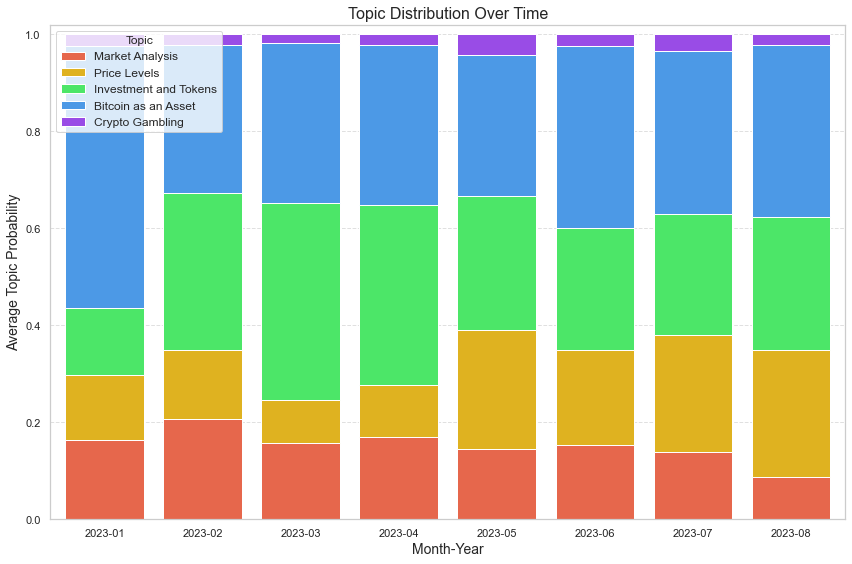

In [38]:
topic_columns = ['Topic 1', 'Topic 2', 'Topic 3', 'Topic 4', 'Topic 5']

topic_names = ["Market Analysis", "Price Levels", "Investment and Tokens", 
               "Bitcoin as an Asset", "Crypto Gambling"]

topic_distribution = df.groupby('MonthYear')[topic_columns].mean()

custom_palette = ['#FF5733', '#FFC300', '#33FF57', '#3399FF', '#9933FF']

sns.set(style="whitegrid")

plt.figure(figsize=(12, 8))

ax = sns.barplot(data=topic_distribution.reset_index(), x='MonthYear', y=topic_columns[0], color=custom_palette[0], label=topic_names[0])
for i in range(1, len(topic_columns)):
    ax = sns.barplot(data=topic_distribution.reset_index(), x='MonthYear', y=topic_columns[i], color=custom_palette[i], label=topic_names[i], bottom=topic_distribution[topic_columns[:i]].sum(axis=1))

plt.title("Topic Distribution Over Time", fontsize=16)
plt.xlabel("Month-Year", fontsize=14)
plt.ylabel("Average Topic Probability", fontsize=14)
plt.legend(title="Topic", loc='upper left', fontsize=12)

ax.yaxis.grid(True, linestyle='--', alpha=0.6)

plt.margins(0.02)

plt.tight_layout()
plt.show()

